In [26]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import os
import random
import shutil
import torchvision.datasets as datasets
import torchvision
import tqdm
import sklearn
import sklearn.datasets
from tensorboardX import SummaryWriter
from dataset import random_split

In [4]:
GPU_MODE = True
data_dir = 'data/'

In [5]:
classes = ['healthy', 'Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 
           'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_mosaic_virus', 
          'Tomato_Yellow_Leaf_Curl_Virus']
binary_classes = ['healthy', 'non_healthy']

if os.path.exists(data_dir):
    shutil.rmtree(data_dir)
os.mkdir(data_dir)
os.mkdir(data_dir + 'test')
os.mkdir(data_dir + 'test/healthy')

shutil.copytree("original_dataset/healthy", data_dir + "train/healthy")
for i in range(int(len(os.listdir(data_dir + 'train/healthy')) * 0.2)): #testing parameter
    src = random.choice(os.listdir(data_dir + "train/healthy"))
    shutil.move(data_dir + "train/healthy/" + src, data_dir + "test/healthy/" + src)
    
os.mkdir(data_dir + 'train/non_healthy')
os.mkdir(data_dir + 'test/non_healthy')
for cls in tqdm.tqdm(list(classes[1:])):
    for i in range(133):
        src = random.choice(os.listdir("original_dataset/" + cls))
        shutil.copyfile("original_dataset/" + cls + '/' + src, data_dir + "train/non_healthy/" + src)#will become copytree
    for i in range(33):
        src = random.choice(os.listdir(data_dir + "train/non_healthy"))
        shutil.move(data_dir + "train/non_healthy/" + src, data_dir + "test/non_healthy/" + src)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.29s/it]


In [36]:
batch_size = 16
data_transforms = {
        'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
        'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                      data_transforms[x]) for x in ['train', 'test']}

train_dataset_len = len(image_datasets['train'])
image_datasets['train'], image_datasets['val'] = random_split(image_datasets['train'], [train_dataset_len//2, train_dataset_len-train_dataset_len//2] )
    
    
"""trainloader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size,
                                         shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size,
                                         shuffle=True, num_workers=8)"""
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
shuffle=True, num_workers=8) for x in ['train', 'val', 'test']}


<built-in method items of dict object at 0x000002A122D595E8>


healthy healthy non_healthy healthy healthy healthy healthy healthy non_healthy healthy non_healthy non_healthy healthy healthy healthy healthy


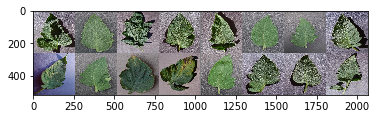

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % binary_classes[labels[j]] for j in range(batch_size)))

In [6]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # 3 input image channel,
        # 6 output channel,
        # 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 4, 5)
        self.conv2 = nn.Conv2d(4, 6, 5)
        self.conv3 = nn.Conv2d(6, 16, 5)
        # an affine operation
        self.fc1 = nn.Linear(16 * 28 * 28, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        
    def forward(self, x):
        # max pooling over a (2, 2) windows
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
model = Model()
if GPU_MODE:
    model = model.cuda()
    
print(model)

Model(
  (conv1): Conv2d (3, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d (4, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d (6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=12544, out_features=120)
  (fc2): Linear(in_features=120, out_features=84)
  (fc3): Linear(in_features=84, out_features=2)
)


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 10
num_batches = 32
num_iterations = 0

log_dir = 'log/'
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
writer = SummaryWriter(log_dir)

for epoch in tqdm.tqdm(list(range(num_epochs))):  # loop over the dataset multiple epochs

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        if GPU_MODE:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        optimizer.zero_grad() # zero the gradient buffers

        # forward + loss + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() # does the update

        # print statistics
        running_loss += loss.data[0]
        if i % num_batches == num_batches - 1:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / num_batches))
            num_iterations += i
            writer.add_scalar('train/loss', running_loss, num_iterations)
            running_loss = 0.0
        
print('Finished Training.')

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

[1,    32] loss: 0.692
[1,    64] loss: 0.666
[1,    96] loss: 0.671
[1,   128] loss: 0.661


  2%|█▋                                                                                 | 1/50 [00:17<14:02, 17.20s/it]

[2,    32] loss: 0.642
[2,    64] loss: 0.636
[2,    96] loss: 0.613
[2,   128] loss: 0.571


  4%|███▎                                                                               | 2/50 [00:34<13:49, 17.29s/it]

[3,    32] loss: 0.601
[3,    64] loss: 0.504
[3,    96] loss: 0.479
[3,   128] loss: 0.477


  6%|████▉                                                                              | 3/50 [00:51<13:23, 17.10s/it]

[4,    32] loss: 0.400
[4,    64] loss: 0.358
[4,    96] loss: 0.317
[4,   128] loss: 0.314


  8%|██████▋                                                                            | 4/50 [01:09<13:15, 17.30s/it]

[5,    32] loss: 0.268
[5,    64] loss: 0.225
[5,    96] loss: 0.212
[5,   128] loss: 0.172


 10%|████████▎                                                                          | 5/50 [01:26<12:58, 17.31s/it]

[6,    32] loss: 0.137
[6,    64] loss: 0.233
[6,    96] loss: 0.177
[6,   128] loss: 0.135


 12%|█████████▉                                                                         | 6/50 [01:44<12:45, 17.41s/it]

[7,    32] loss: 0.160
[7,    64] loss: 0.134
[7,    96] loss: 0.214
[7,   128] loss: 0.184


 14%|███████████▌                                                                       | 7/50 [02:02<12:31, 17.47s/it]

[8,    32] loss: 0.109
[8,    64] loss: 0.070
[8,    96] loss: 0.166
[8,   128] loss: 0.080


 16%|█████████████▎                                                                     | 8/50 [02:21<12:25, 17.75s/it]

[9,    32] loss: 0.084
[9,    64] loss: 0.055
[9,    96] loss: 0.117
[9,   128] loss: 0.107


 18%|██████████████▉                                                                    | 9/50 [02:39<12:08, 17.77s/it]

[10,    32] loss: 0.100
[10,    64] loss: 0.045
[10,    96] loss: 0.048
[10,   128] loss: 0.061


 20%|████████████████▍                                                                 | 10/50 [02:58<11:54, 17.87s/it]

[11,    32] loss: 0.078
[11,    64] loss: 0.122
[11,    96] loss: 0.154
[11,   128] loss: 0.046


 22%|██████████████████                                                                | 11/50 [03:17<11:40, 17.97s/it]

[12,    32] loss: 0.037
[12,    64] loss: 0.051
[12,    96] loss: 0.029
[12,   128] loss: 0.070


 24%|███████████████████▋                                                              | 12/50 [03:36<11:24, 18.01s/it]

[13,    32] loss: 0.071
[13,    64] loss: 0.050
[13,    96] loss: 0.032
[13,   128] loss: 0.073


 26%|█████████████████████▎                                                            | 13/50 [03:55<11:10, 18.13s/it]

[14,    32] loss: 0.057
[14,    64] loss: 0.027
[14,    96] loss: 0.031
[14,   128] loss: 0.043


 28%|██████████████████████▉                                                           | 14/50 [04:14<10:55, 18.21s/it]

[15,    32] loss: 0.018
[15,    64] loss: 0.022
[15,    96] loss: 0.030
[15,   128] loss: 0.048


 30%|████████████████████████▌                                                         | 15/50 [04:34<10:39, 18.28s/it]

[16,    32] loss: 0.046
[16,    64] loss: 0.043
[16,    96] loss: 0.082
[16,   128] loss: 0.036


 32%|██████████████████████████▏                                                       | 16/50 [04:53<10:23, 18.34s/it]

[17,    32] loss: 0.027
[17,    64] loss: 0.016
[17,    96] loss: 0.018
[17,   128] loss: 0.033


 34%|███████████████████████████▉                                                      | 17/50 [05:13<10:08, 18.44s/it]

[18,    32] loss: 0.052
[18,    64] loss: 0.039
[18,    96] loss: 0.175
[18,   128] loss: 0.051


 36%|█████████████████████████████▌                                                    | 18/50 [05:33<09:53, 18.53s/it]

[19,    32] loss: 0.070
[19,    64] loss: 0.041
[19,    96] loss: 0.024
[19,   128] loss: 0.015


 38%|███████████████████████████████▏                                                  | 19/50 [05:53<09:37, 18.62s/it]

[20,    32] loss: 0.012
[20,    64] loss: 0.025
[20,    96] loss: 0.012
[20,   128] loss: 0.034


 40%|████████████████████████████████▊                                                 | 20/50 [06:14<09:21, 18.72s/it]

[21,    32] loss: 0.028
[21,    64] loss: 0.028
[21,    96] loss: 0.018
[21,   128] loss: 0.012


 42%|██████████████████████████████████▍                                               | 21/50 [06:34<09:04, 18.78s/it]

[22,    32] loss: 0.004
[22,    64] loss: 0.014
[22,    96] loss: 0.033
[22,   128] loss: 0.056


 44%|████████████████████████████████████                                              | 22/50 [06:54<08:47, 18.84s/it]

[23,    32] loss: 0.020
[23,    64] loss: 0.039
[23,    96] loss: 0.009
[23,   128] loss: 0.011


 46%|█████████████████████████████████████▋                                            | 23/50 [07:13<08:28, 18.85s/it]

[24,    32] loss: 0.009
[24,    64] loss: 0.007
[24,    96] loss: 0.003
[24,   128] loss: 0.023


 48%|███████████████████████████████████████▎                                          | 24/50 [07:32<08:10, 18.87s/it]

[25,    32] loss: 0.041
[25,    64] loss: 0.018
[25,    96] loss: 0.017
[25,   128] loss: 0.023


 50%|█████████████████████████████████████████                                         | 25/50 [07:52<07:52, 18.91s/it]

[26,    32] loss: 0.017
[26,    64] loss: 0.014
[26,    96] loss: 0.012
[26,   128] loss: 0.034


 52%|██████████████████████████████████████████▋                                       | 26/50 [08:13<07:35, 18.98s/it]

[27,    32] loss: 0.011
[27,    64] loss: 0.003
[27,    96] loss: 0.008
[27,   128] loss: 0.004


 54%|████████████████████████████████████████████▎                                     | 27/50 [08:34<07:18, 19.05s/it]

[28,    32] loss: 0.003
[28,    64] loss: 0.014
[28,    96] loss: 0.012
[28,   128] loss: 0.002


 56%|█████████████████████████████████████████████▉                                    | 28/50 [08:54<07:00, 19.11s/it]

[29,    32] loss: 0.004
[29,    64] loss: 0.001
[29,    96] loss: 0.012


KeyboardInterrupt: 

GroundTruth:  healthy non_healthy non_healthy non_healthy healthy healthy healthy healthy non_healthy healthy non_healthy non_healthy healthy non_healthy non_healthy healthy


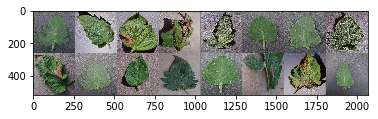

In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % binary_classes[labels[j]] for j in range(16)))

In [9]:
if GPU_MODE:
    outputs = model(Variable(images).cuda())
else:
    outputs = model(Variable(images))

_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % binary_classes[predicted.cpu()[j]]
                              for j in range(16)))

Predicted:  healthy non_healthy non_healthy non_healthy healthy healthy healthy healthy non_healthy healthy non_healthy non_healthy healthy non_healthy non_healthy healthy


In [10]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    if GPU_MODE:
        outputs = model(Variable(images).cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum()
    else:
        outputs = model(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 98 %


In [11]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
for data in testloader:
    images, labels = data
    if GPU_MODE:
        outputs = model(Variable(images).cuda())
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted.cpu() == labels).squeeze()
    else:
        outputs = model(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze() 
    for i in range(2):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

for i in range(2):
    print('Accuracy of %5s : %2d %%' % (binary_classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of healthy : 100 %
Accuracy of non_healthy : 100 %
